# Setup

In [1]:
# Don't do this. Do as I say and not as I code.
import sys
sys.path.insert(0, "../") 

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from data_utils import (generate_data, test_data)
from mpl_utils import mpl_style

from model import LatentClusteringModel

plt.style.use(mpl_style)

%matplotlib inline

In [2]:
def orient_factors(true, inferred):
    J, D = true.shape
    if true.shape != inferred.shape:
        raise ValueError("true and inferred factor loads must be the same shape")
    
    jdx = np.zeros(J, dtype=int)
    for j in range(J):
        d = np.sum((np.abs(true) - np.abs(inferred[j]))**2, axis=1)
        jdx[j] = np.argmin(d)
    
    assert len(set(jdx)) == len(jdx), "Our dumb matching failed"
        
    # Now flip as needed.
    signs = np.ones(J)
    for j in range(J):
        A = np.vstack((np.ones(D), true[j])).T
        C = np.eye(D)
        cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
        b, m = np.dot(cov, np.dot(A.T, np.linalg.solve(C, inferred[j])))
        signs[j] = np.sign(m)

    return (jdx, signs)

def orient_factors_in_model(true, model):
    jdx, signs = orient_factors(true["L"], model._factor_loads)
    model._factor_loads *= signs.reshape(J, -1) 
    model._factor_scores *= signs.reshape(-1, J)
        
    model._factor_loads = model._factor_loads[jdx]
    model._factor_scores = model._factor_scores.T[jdx].T
    
    return (model, jdx, signs)

# No clustering in the factor scores

In [3]:
seed = 42

J = 3     # number of latent factors
D = 10    # dimensionality of data
N = 10000 # number of data points
K = 1     # number of clusters

data_kwds = dict(N=N, D=D, J=J, K=K, seed=seed, full_output=True,
                 __cluster_mu_theta_scale=1, __cluster_sigma_theta_scale=1)
data, truths = generate_data(**data_kwds)

if len(truths["psi"].shape) == 2:
    truths["psi"] = np.diag(truths["psi"])

In [4]:
model = LatentClusteringModel(n_components=J, tol=1e-2)
model.fit(data["y"])

0 -141140.8389469144
1 -139165.6234793739
2 -138314.6024474995
3 -138001.0023324163
4 -137875.96514263982
5 -137819.90065069083
6 -137791.98617266907
7 -137776.73256180828
8 -137767.64211340138
9 -137761.75264625766
10 -137757.62357265403
11 -137754.5193413704
12 -137752.0495936268
13 -137749.99969823455
14 -137748.2470165457
15 -137746.71815312002
16 -137745.36665324421
17 -137744.16119500567
18 -137743.07926447535
19 -137742.10372535046
20 -137741.22092523138
21 -137740.4196208665
22 -137739.69034224434
23 -137739.02499444727
24 -137738.416591125
25 -137737.8590635914
26 -137737.34711583698
27 -137736.87610943592
28 -137736.4419694093
29 -137736.04110577557
30 -137735.67034743784
31 -137735.32688609953
32 -137735.00822849167
33 -137734.71215556478
34 -137734.43668755365
35 -137734.18005400425
36 -137733.94066800756
37 -137733.7171040011
38 -137733.50807860072
39 -137733.31243401155
40 -137733.12912363643
41 -137732.957199561
42 -137732.79580164375
43 -137732.64414798465
44 -137732.50

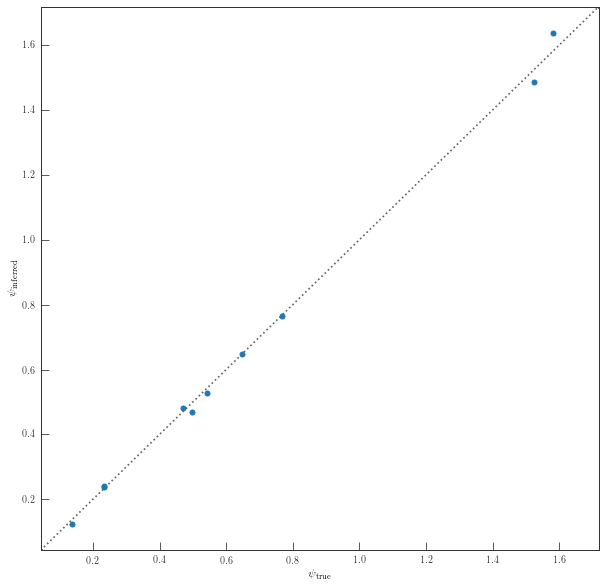

In [5]:
# psi 
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(truths["psi"], model._noise_variance)
limits = np.array([ax.get_xlim(), ax.get_ylim()])
limits = (np.min(limits), np.max(limits))
ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
ax.set_xlim(limits)
ax.set_ylim(limits)

ax.set_xlabel(r"$\psi_\textrm{true}$")
ax.set_ylabel(r"$\psi_\textrm{inferred}$")

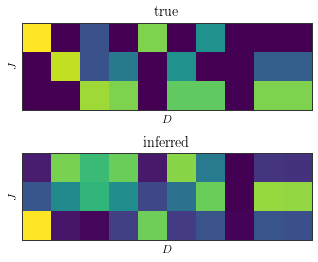

In [6]:
# The factor loads between true and inferred will not line up exactly.
# Need to infer which is which.
fig, axes = plt.subplots(2)
axes[0].imshow(np.abs(truths["L"]), interpolation="nearest")
axes[1].imshow(np.abs(model._factor_loads), interpolation="nearest")
for ax in axes:
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_xlabel(r"$D$")
    ax.set_ylabel(r"$J$")
    
axes[0].set_title(r"\textrm{true}")
axes[1].set_title(r"\textrm{inferred}")

In [7]:
# Orient and flip the signs
model, jdx, signs = orient_factors_in_model(truths, model)

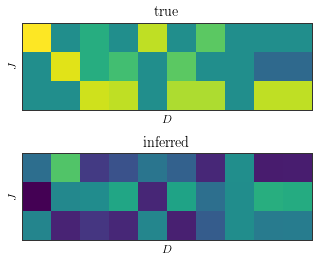

In [8]:
v = np.hstack([truths["L"], model._factor_loads]).flatten()
kwds = dict(interpolation="nearest", vmin=np.min(v), vmax=np.max(v))

fig, axes = plt.subplots(2)
axes[0].imshow(truths["L"], **kwds)
axes[1].imshow(model._factor_loads, **kwds)
for ax in axes:
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_xlabel(r"$D$")
    ax.set_ylabel(r"$J$")
    
axes[0].set_title(r"\textrm{true}")
axes[1].set_title(r"\textrm{inferred}")

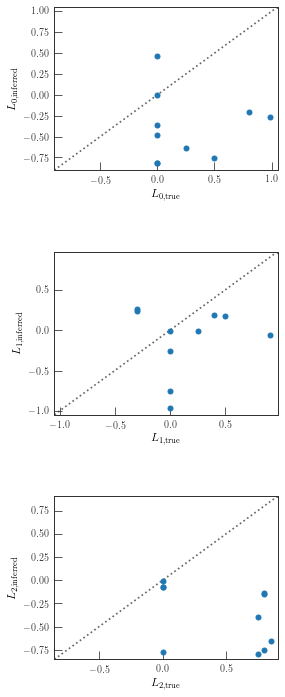

In [9]:
# Factor loads.
fig, axes = plt.subplots(J, 1, figsize=(4, 4*J))
for j, ax in enumerate(axes):
    ax.scatter(truths["L"][j], model._factor_loads[j])
    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    limits = (np.min(limits), np.max(limits))
    ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_xlabel(r"$L_{{{0},\textrm{{true}}}}$".format(j))
    ax.set_ylabel(r"$L_{{{0},\textrm{{inferred}}}}$".format(j))

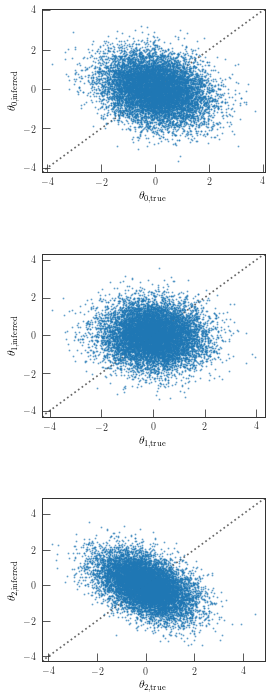

In [10]:
# Factor scores.

kwds = dict(alpha=0.5, s=1)
fig, axes = plt.subplots(J, 1, figsize=(4, 4*J))
for j, ax in enumerate(axes):
    ax.scatter(truths["theta"].T[j], model._factor_scores.T[j], **kwds)
    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    limits = (np.min(limits), np.max(limits))
    ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_xlabel(r"$\theta_{{{0},\textrm{{true}}}}$".format(j))
    ax.set_ylabel(r"$\theta_{{{0},\textrm{{inferred}}}}$".format(j))

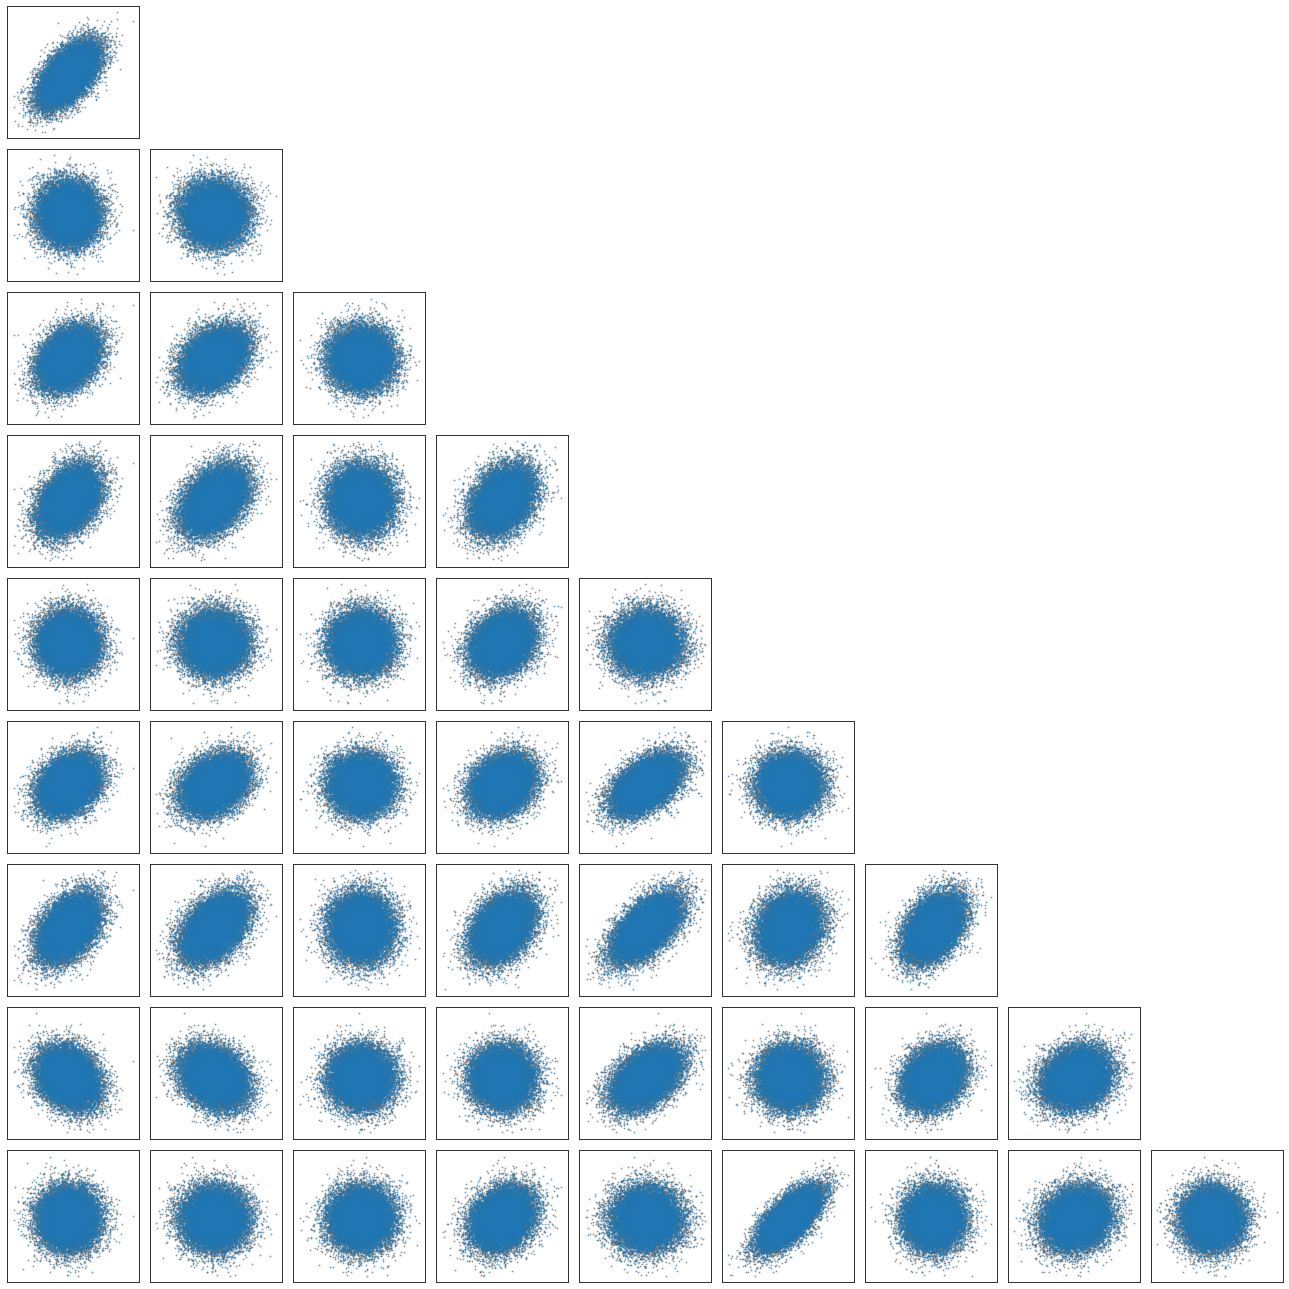

In [11]:
# Predict data?
from mpl_utils import corner_scatter_compare

y_p = np.dot(model._factor_scores, model._factor_loads) \
    + np.random.multivariate_normal(np.zeros(D), np.eye(D) * model._noise_variance, size=N)

fig = corner_scatter_compare(data["y"], y_p)

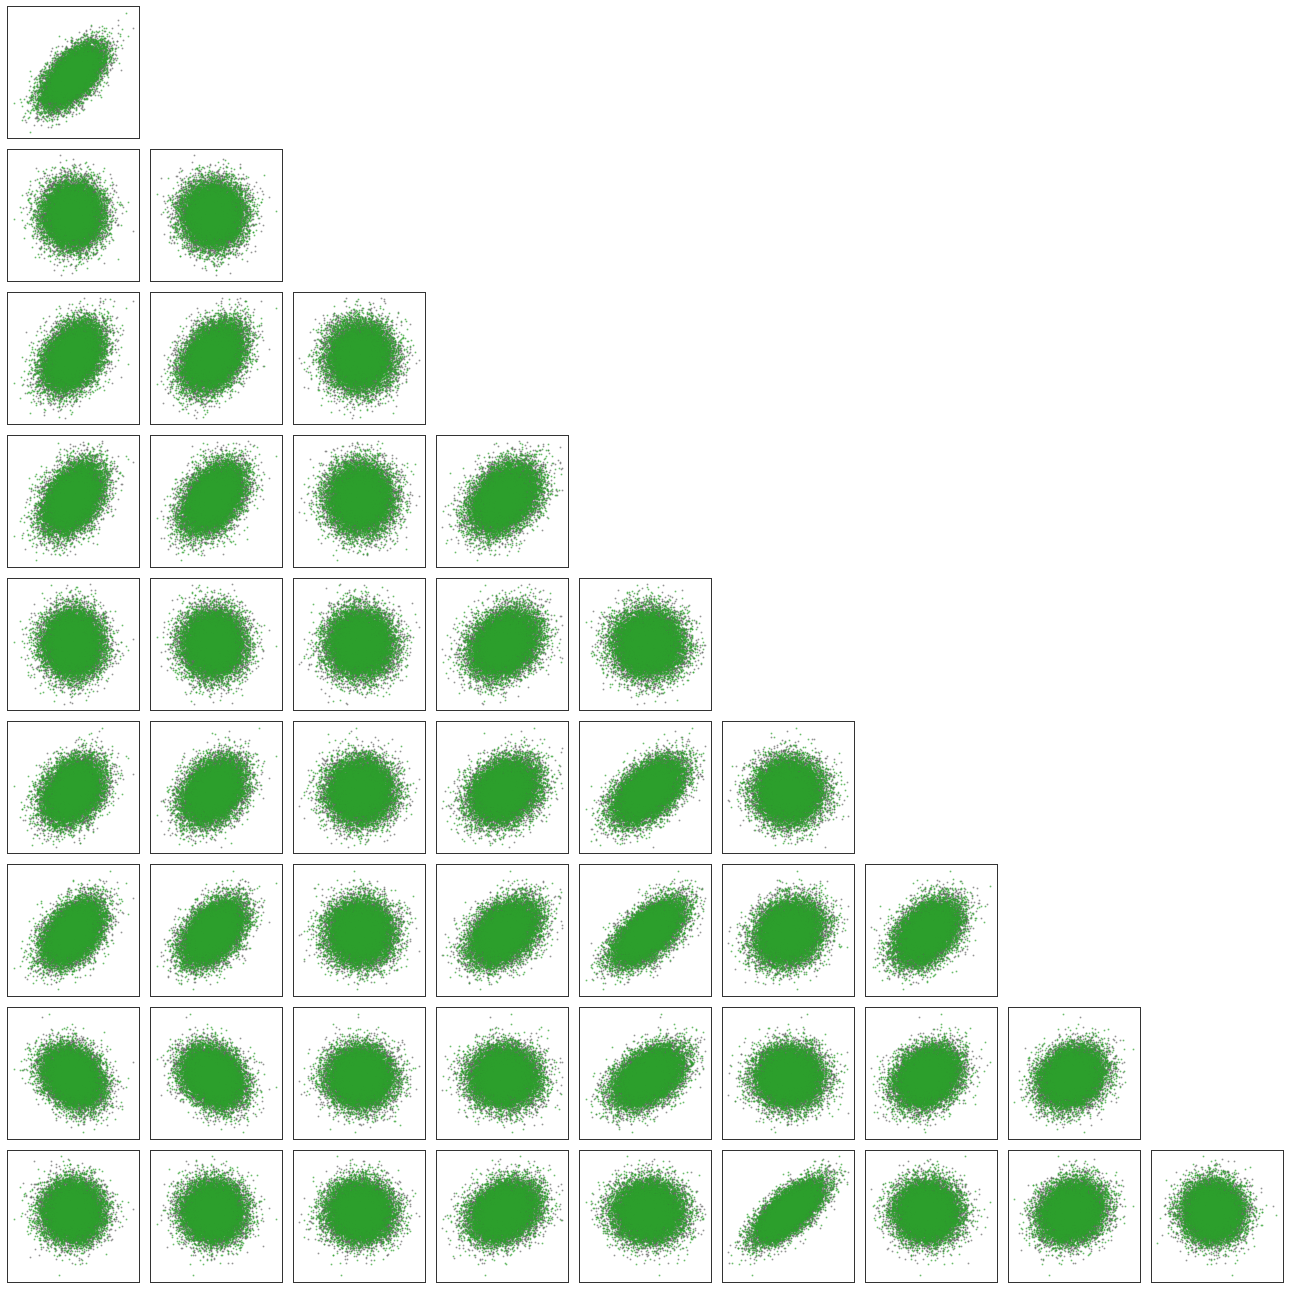

In [12]:
# Compare with truth.
y_t = np.dot(truths["theta"], truths["L"]) \
    + np.random.multivariate_normal(np.zeros(D), np.eye(D) * truths["psi"], size=N)
    
fig = corner_scatter_compare(data["y"], y_t, scatter_kwds_2=dict(c="tab:green"))

# With simulated clusters in the factor scores.

In [76]:
K = 2

data_kwds = dict(N=N, D=D, J=J, K=K, seed=seed, full_output=True,
                 __cluster_mu_theta_scale=1, __cluster_sigma_theta_scale=0.1)
data_c, truths_c = generate_data(**data_kwds)

if len(truths_c["psi"].shape) == 2:
    truths_c["psi"] = np.diag(truths_c["psi"])

# generate a responsibility matrix that is more familiar.
R = np.zeros((N, K), dtype=float)
for k in range(data_kwds["K"]):
    R[:, k] = (truths_c["responsibility"] == k).astype(int)

# Calculate the offsets (in data space) due to the clustering in factor scores
offset = np.dot(np.dot(R, truths_c["cluster_mu_theta"]), truths_c["L"])

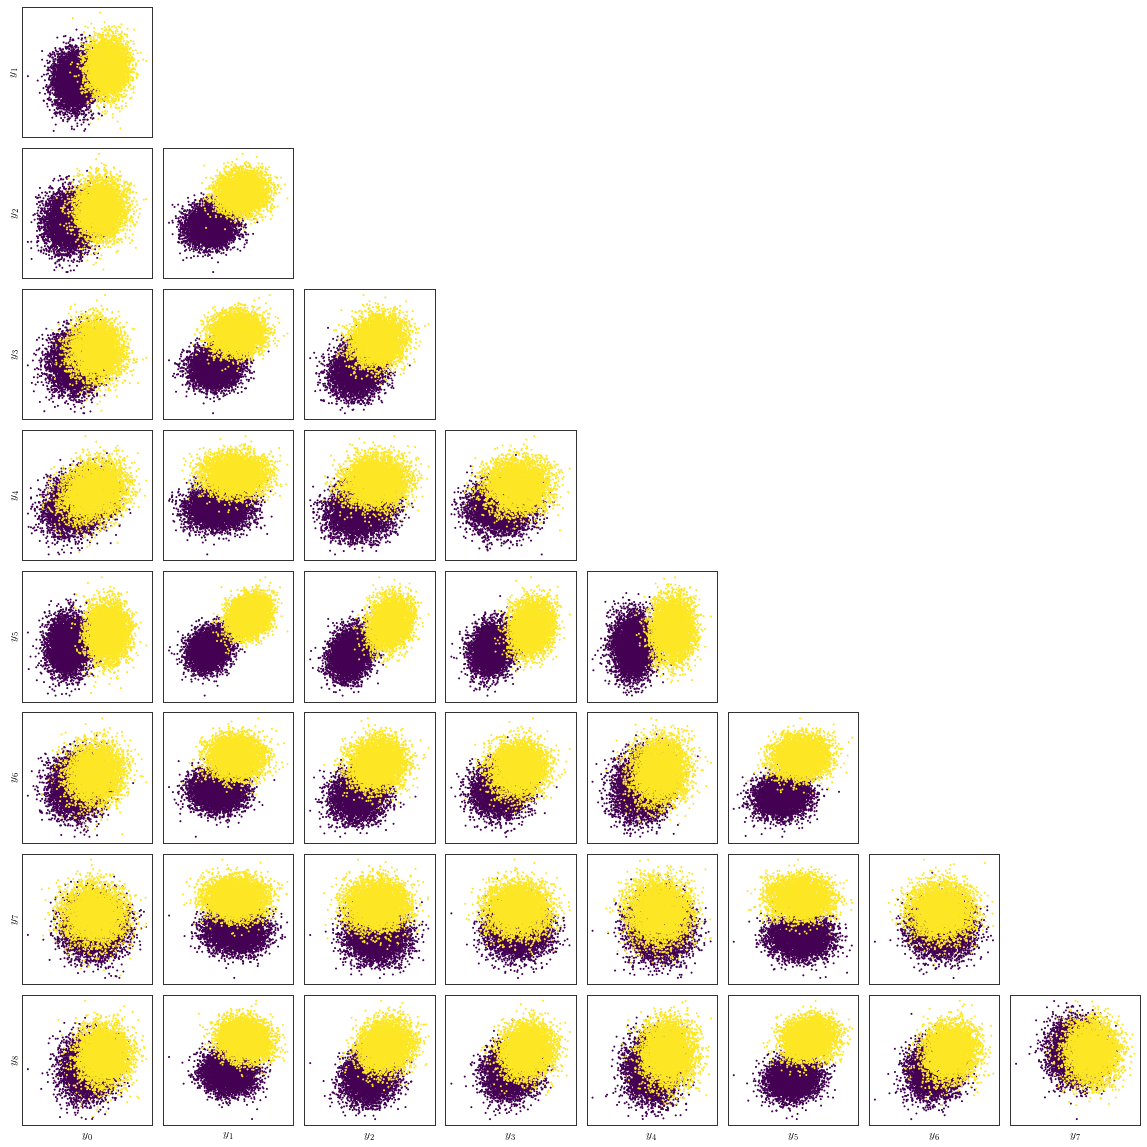

In [77]:
# Plot the data.
A = data_c["D"] - 1
fig, axes = plt.subplots(A, A, figsize=(2 * A, 2 * A))

ordered = True

y = data_c["y"]

c = truths_c["responsibility"]    
indices = np.argsort(c) if ordered else np.arange(len(c))
kwds = dict(s=1, alpha=1, c=c[indices])

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        if j >= i:
            ax.set_visible(False)
            continue
            
        ax.scatter(y.T[i][indices], y.T[j][indices], **kwds)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if ax.is_last_row():
            ax.set_xlabel(r"$y_{{{0}}}$".format(j))
        if ax.is_first_col():
            ax.set_ylabel(r"$y_{{{0}}}$".format(i))
    
fig.tight_layout()


In [78]:
# Try a model with no clustering
model_nc = LatentClusteringModel(n_components=J, tol=1e-2)
model_nc.fit(data_c["y"])

0 -128913.58600565937
1 -128181.97905790975
2 -128000.62171111822
3 -127932.11067588204
4 -127894.73845837929
5 -127860.12606897889
6 -127788.18609434942
7 -127628.48404680993
8 -127516.63171040188
9 -127455.5629203231
10 -127438.03589095536
11 -127433.23195193917
12 -127431.33402608531
13 -127430.2689719606
14 -127429.50337077197
15 -127428.88121153443
16 -127428.34945733429
17 -127427.88534369638
18 -127427.47613896112
19 -127427.11313290775
20 -127426.78965332708
21 -127426.50030096484
22 -127426.24059039605
23 -127426.00674477214
24 -127425.79555881507
25 -127425.60429770488
26 -127425.43061806561
27 -127425.27250432083
28 -127425.12821661608
29 -127424.99624785468
30 -127424.87528807823
31 -127424.76419484089
32 -127424.6619685022
33 -127424.5677315645
34 -127424.48071134652
35 -127424.40022541159
36 -127424.3256692762
37 -127424.25650600891
38 -127424.19225739977
39 -127424.13249644202
40 -127424.07684090779
41 -127424.02494784206
42 -127423.97650882967
43 -127423.93124591396
44 

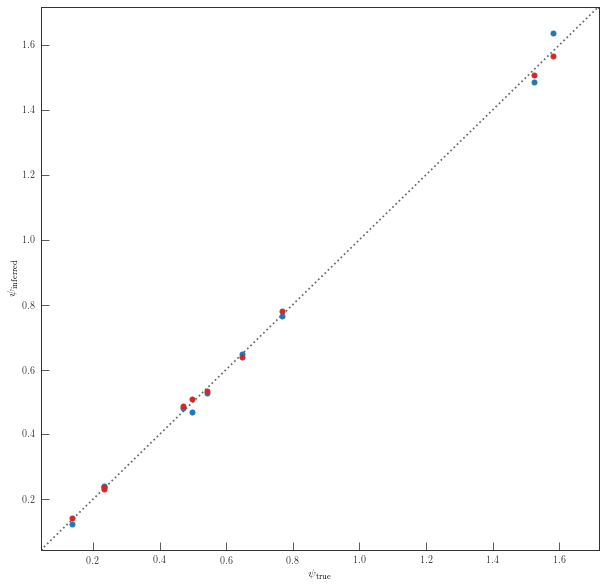

In [79]:
# psi 
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(truths["psi"], model._noise_variance, c="tab:blue")

ax.scatter(truths_c["psi"], model_nc._noise_variance, c="tab:red")
limits = np.array([ax.get_xlim(), ax.get_ylim()])
limits = (np.min(limits), np.max(limits))
ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
ax.set_xlim(limits)
ax.set_ylim(limits)

ax.set_xlabel(r"$\psi_\textrm{true}$")
ax.set_ylabel(r"$\psi_\textrm{inferred}$")

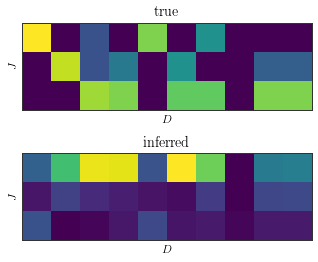

In [80]:
# The factor loads between true and inferred will not line up exactly.
# Need to infer which is which.
fig, axes = plt.subplots(2)
axes[0].imshow(np.abs(truths_c["L"]), interpolation="nearest")
axes[1].imshow(np.abs(model_nc._factor_loads), interpolation="nearest")
for ax in axes:
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_xlabel(r"$D$")
    ax.set_ylabel(r"$J$")
    
axes[0].set_title(r"\textrm{true}")
axes[1].set_title(r"\textrm{inferred}")

In [81]:
model_nc, jdx, signs = orient_factors_in_model(truths_c, model_nc)
print(signs)
model_nc, jdx, signs = orient_factors_in_model(truths_c, model_nc)
print(signs)

[-1.  1. -1.]
[-1.  1. -1.]


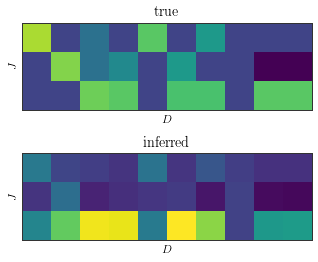

In [82]:
v = np.hstack([truths_c["L"], model_nc._factor_loads]).flatten()
kwds = dict(interpolation="nearest", vmin=np.min(v), vmax=np.max(v))

fig, axes = plt.subplots(2)
axes[0].imshow(truths_c["L"], **kwds)
axes[1].imshow(model_nc._factor_loads, **kwds)
for ax in axes:
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_xlabel(r"$D$")
    ax.set_ylabel(r"$J$")
    
axes[0].set_title(r"\textrm{true}")
axes[1].set_title(r"\textrm{inferred}")

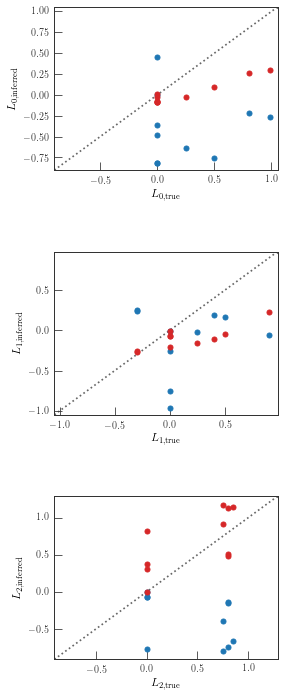

In [83]:
# Factor loads.
fig, axes = plt.subplots(J, 1, figsize=(4, 4*J))
for j, ax in enumerate(axes):
    ax.scatter(truths["L"][j], model._factor_loads[j], c="tab:blue")
    ax.scatter(truths_c["L"][j], model_nc._factor_loads[j], c="tab:red")
    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    limits = (np.min(limits), np.max(limits))
    ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_xlabel(r"$L_{{{0},\textrm{{true}}}}$".format(j))
    ax.set_ylabel(r"$L_{{{0},\textrm{{inferred}}}}$".format(j))

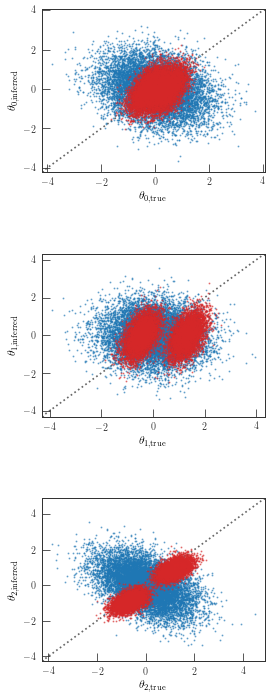

In [84]:
# Factor scores.
kwds = dict(alpha=0.5, s=1)
fig, axes = plt.subplots(J, 1, figsize=(4, 4*J))
for j, ax in enumerate(axes):
    ax.scatter(truths["theta"].T[j], model._factor_scores.T[j],
               c="tab:blue", **kwds)
    ax.scatter(truths_c["theta"].T[j], model_nc._factor_scores.T[j],
               c="tab:red", **kwds)
    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    limits = (np.min(limits), np.max(limits))
    ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_xlabel(r"$\theta_{{{0},\textrm{{true}}}}$".format(j))
    ax.set_ylabel(r"$\theta_{{{0},\textrm{{inferred}}}}$".format(j))

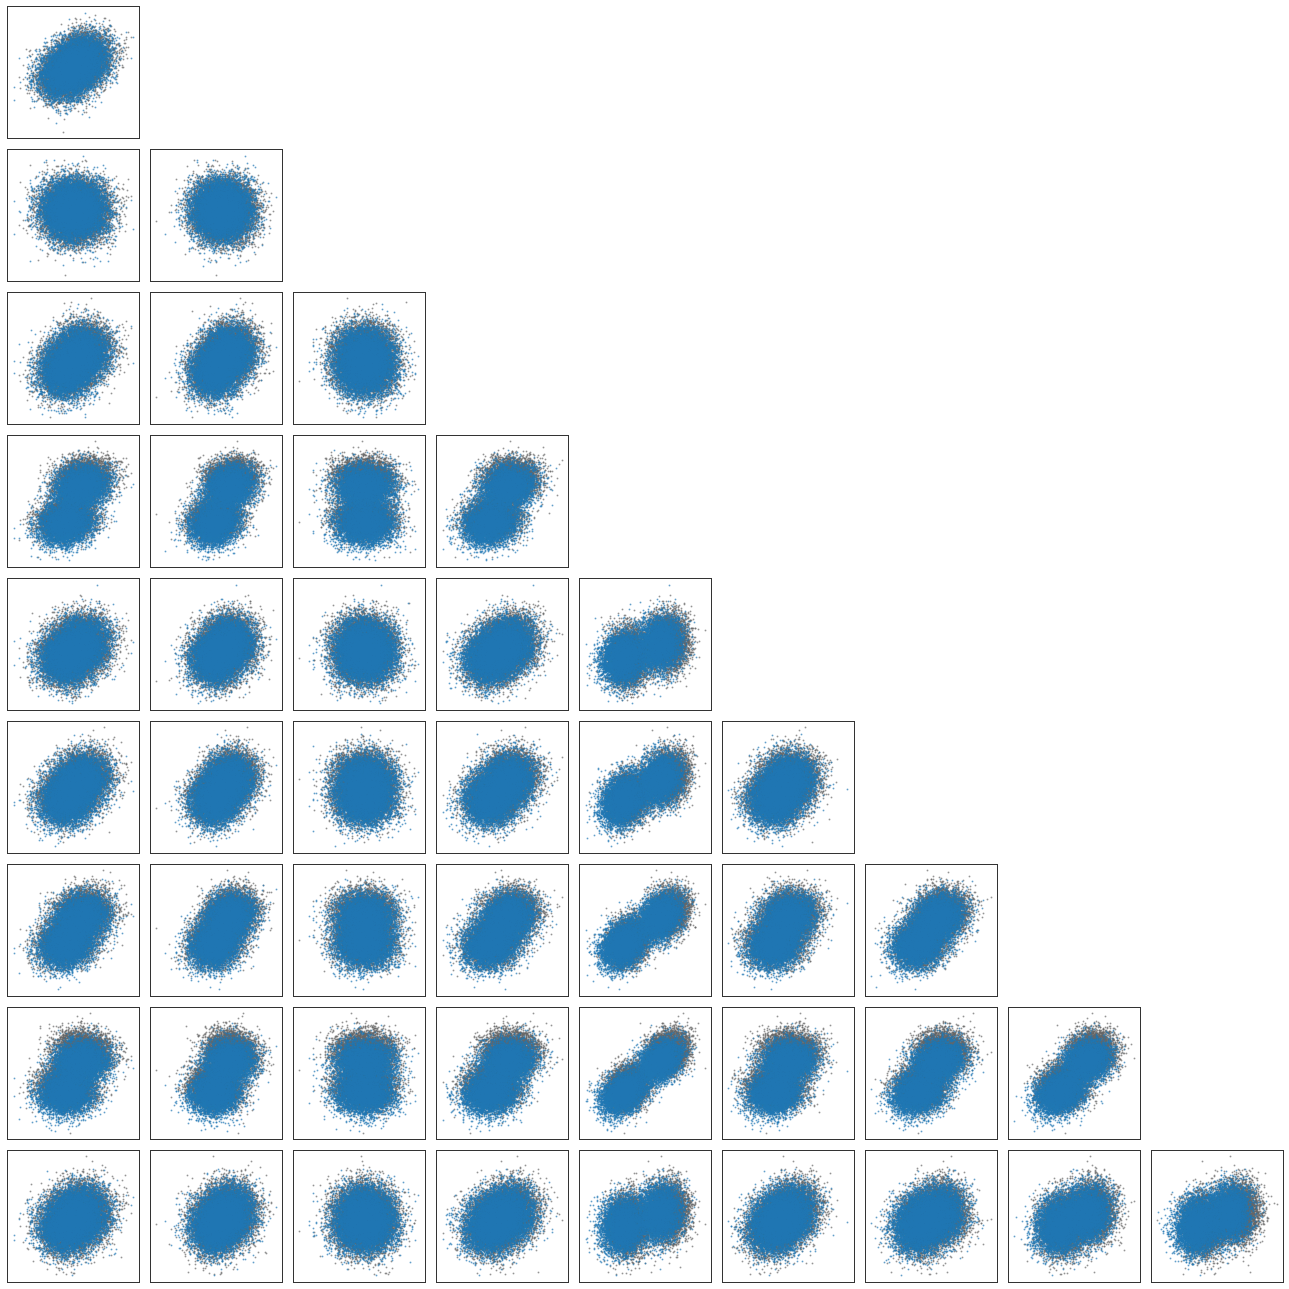

In [85]:
# Predict data?
y_p = np.dot(model_nc._factor_scores, model_nc._factor_loads) \
    + np.random.multivariate_normal(np.zeros(D), 
                                    np.eye(D) * model_nc._noise_variance, 
                                    size=N)

fig = corner_scatter_compare(data_c["y"], y_p)

Slight offsets due to the clustering in factor scores. Let's look at them

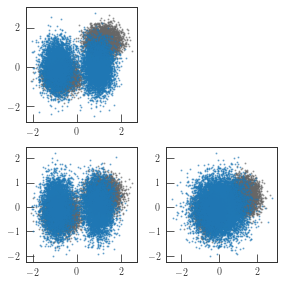

In [86]:
fig = corner_scatter_compare(truths_c["theta"], model_nc._factor_scores,
                             show_ticks=True)

Fit with clustering and see what happens.

In [87]:
model_wc = LatentClusteringModel(n_components=J, n_clusters=K, tol=1e-2)
model_wc.fit(data_c["y"])

0 -133724.62316992017
1 -138041.3497021453
2 -138128.59114725655
3 -138439.1726811142
4 -137555.12728857985
5 -138202.3391690862
6 -136835.90467896583
7 -138105.6731246233
8 -136541.73521954255
9 -138087.60090412037
10 -136492.52958890158
11 -138086.20866368889
12 -136489.76845589676
13 -138086.46319057903
14 -136490.89419646346
15 -138086.54678323146
16 -136491.42387440713
17 -138086.5059585411
18 -136491.52608343898
19 -138086.43965652844
20 -136491.47446535088
21 -138086.3811518197
22 -136491.3736975561
23 -138086.3367816395
24 -136491.253453507
25 -138086.30685939125
26 -136491.11948667237
27 -138086.29220670526
28 -136490.97038240623
29 -138086.29579926512
30 -136490.80224632882
31 -138086.32296500436
32 -136490.61017445914
33 -138086.3807301426
34 -136490.38923599874
35 -138086.4761475501
36 -136490.13559708305
37 -138086.61378720796
38 -136489.8475143528
39 -138086.79346217358
40 -136489.52549658823
41 -138087.00971743377
42 -136489.17130127084
43 -138087.2536417065
44 -136488.7

351 -138116.1027228507
352 -136381.55922644556
353 -138116.1027227337
354 -136381.55922624792
355 -138116.10272268014
356 -136381.55922621922
357 -138116.1027226323
358 -136381.5592261174
359 -138116.10272277857
360 -136381.55922636067
361 -138116.1027227208
362 -136381.55922607664
363 -138116.10272284245
364 -136381.55922635566
365 -138116.10272275482
366 -136381.55922625074
367 -138116.10272271154
368 -136381.55922618357
369 -138116.10272263165
370 -136381.55922612068
371 -138116.10272278683
372 -136381.55922628683
373 -138116.10272274574
374 -136381.55922618762
375 -138116.10272286972
376 -136381.55922646198
377 -138116.10272291364
378 -136381.55922652694
379 -138116.10272277944
380 -136381.5592263159
381 -138116.10272272743
382 -136381.55922623555
383 -138116.10272282982
384 -136381.55922635636
385 -138116.10272280077
386 -136381.5592263673
387 -138116.1027229182
388 -136381.5592265764
389 -138116.10272289685
390 -136381.5592265212
391 -138116.1027228043
392 -136381.55922630595
393

702 -136381.5592262556
703 -138116.10272267676
704 -136381.55922625767
705 -138116.10272258963
706 -136381.55922603887
707 -138116.10272270977
708 -136381.5592263846
709 -138116.10272262478
710 -136381.55922611873
711 -138116.10272270968
712 -136381.5592262066
713 -138116.1027228415
714 -136381.55922643366
715 -138116.10272278162
716 -136381.55922630604
717 -138116.1027227402
718 -136381.55922624425
719 -138116.10272270424
720 -136381.55922628348
721 -138116.1027228057
722 -136381.5592264146
723 -138116.10272269783
724 -136381.55922624498
725 -138116.1027227307
726 -136381.5592263607
727 -138116.10272275438
728 -136381.55922634073
729 -138116.10272268095
730 -136381.55922610886
731 -138116.10272266227
732 -136381.55922614114
733 -138116.10272271495
734 -136381.55922632702
735 -138116.10272272764
736 -136381.55922626215
737 -138116.1027227481
738 -136381.5592263043
739 -138116.10272277053
740 -136381.55922625712
741 -138116.10272296477
742 -136381.55922651137
743 -138116.10272289146
744

../model.py:311: ConvergenceWarning: Convergence not achieved: increase the maximum number of iterations
  "number of iterations", ConvergenceWarning)


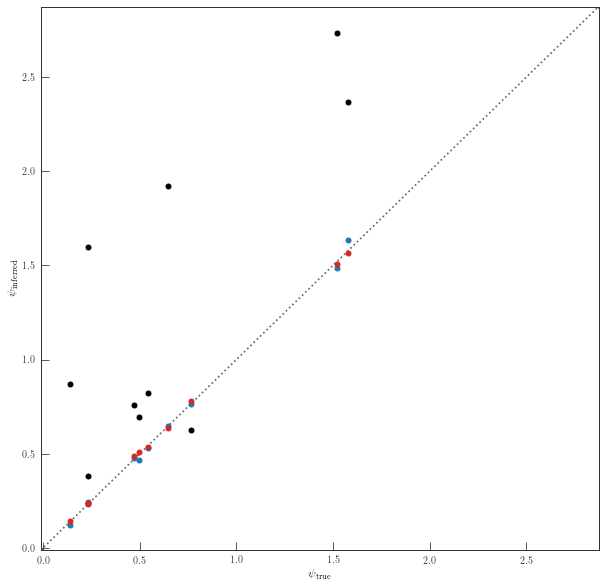

In [88]:
# psi 
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(truths["psi"], model._noise_variance, c="tab:blue")
ax.scatter(truths_c["psi"], model_nc._noise_variance, c="tab:red")
ax.scatter(truths_c["psi"], model_wc._noise_variance, c="k")

limits = np.array([ax.get_xlim(), ax.get_ylim()])
limits = (np.min(limits), np.max(limits))
ax.plot(limits, limits, c="#666666", linestyle=":", zorder=-1)
ax.set_xlim(limits)
ax.set_ylim(limits)

ax.set_xlabel(r"$\psi_\textrm{true}$")
ax.set_ylabel(r"$\psi_\textrm{inferred}$")

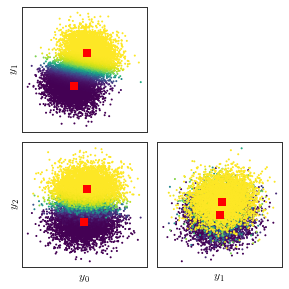

In [89]:
# clustering in factor scores.

marker_kwds = dict(c="r", s=50, lw=0, marker="s", zorder=10)

# Plot the data.
A = data_c["J"]
fig, axes = plt.subplots(A, A, figsize=(2 * A, 2 * A))

ordered = True

y = model_wc._factor_scores

c = model_wc._responsibility.T[0]
indices = np.argsort(c) if ordered else np.arange(len(c))
kwds = dict(s=1, alpha=1, c=c[indices])

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        if j >= i:
            ax.set_visible(False)
            continue
            
        ax.scatter(y.T[i][indices], y.T[j][indices], **kwds)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if ax.is_last_row():
            ax.set_xlabel(r"$y_{{{0}}}$".format(j))
        if ax.is_first_col():
            ax.set_ylabel(r"$y_{{{0}}}$".format(i))
    
        ax.scatter(model_wc._cluster_mu.T[i], 
                   model_wc._cluster_mu.T[j],
                   **marker_kwds)

fig.tight_layout()


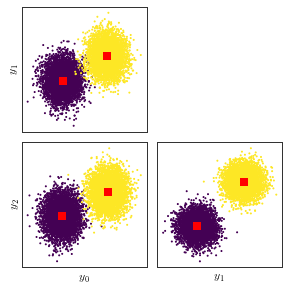

In [94]:
# clustering in factor scores.

A = data_c["J"]
fig, axes = plt.subplots(A, A, figsize=(2 * A, 2 * A))

ordered = True

y = truths_c["theta"]
c = truths_c["responsibility"].flatten()
indices = np.argsort(c) if ordered else np.arange(len(c))
kwds = dict(s=1, alpha=1, c=c[indices])

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        if j >= i:
            ax.set_visible(False)
            continue
            
        ax.scatter(y.T[i][indices], y.T[j][indices], **kwds)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if ax.is_last_row():
            ax.set_xlabel(r"$y_{{{0}}}$".format(j))
        if ax.is_first_col():
            ax.set_ylabel(r"$y_{{{0}}}$".format(i))
    
        ax.scatter(truths_c["cluster_mu_theta"].T[i],
                   truths_c["cluster_mu_theta"].T[j],
                   **marker_kwds)
        
fig.tight_layout()


In [96]:
truths_c["cluster_mu_theta"]

array([[-0.27464375, -0.45721854, -0.6891118 ],
       [ 0.4676901 ,  1.31060591,  1.17110197]])

In [97]:
model_wc._cluster_mu

array([[ 0.60858535,  0.19481346,  0.02037112],
       [-0.65381795, -0.20929281, -0.02188519]])

In [98]:
model_wc._cluster_cov

array([[0.16897642, 0.19828195, 0.07775891],
       [0.15914211, 0.20029947, 0.07778487]])

In [99]:
model_wc._cluster_weight

array([0.5179099, 0.4820901])

In [ ]:
model